In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect("data/idoe_corp_data.db")
curs = conn.cursor()
index_commands = [
    'CREATE INDEX IF NOT EXISTS idx_cees_corpid ON corp_enrollment_ell_sped_2024("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_ctgr_corpid ON corp_third_grade_reading("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_cee_corpid ON corp_enrollment_ethnicity_2024("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_ca_corpid ON corp_act("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_car_corpid ON corp_attendance_rates("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_cca_corpid ON corp_absenteeism("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_ela_corpid ON corp_ilearn_ela("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_math_corpid ON corp_ilearn_math("Corporation ID");',
    'CREATE INDEX IF NOT EXISTS idx_cf_corpid ON corp_finances("Corporation ID");',
]

# Execute each index creation
for cmd in index_commands:
    curs.execute(cmd)


In [3]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table in tables["name"]:
    print(table)
    columns = pd.read_sql_query("PRAGMA table_info("+table+");", conn)
    print(columns["name"])

corp_enrollment_grade_gender
0              Corporation ID
1                   Corp Name
2                Pre-K Female
3                  Pre-K Male
4         Kindergarten Female
5           Kindergarten Male
6              Grade 1 Female
7                Grade 1 Male
8              Grade 2 Female
9                Grade 2 Male
10             Grade 3 Female
11               Grade 3 Male
12             Grade 4 Female
13               Grade 4 Male
14             Grade 5 Female
15               Grade 5 Male
16             Grade 6 Female
17               Grade 6 Male
18             Grade 7 Female
19               Grade 7 Male
20             Grade 8 Female
21               Grade 8 Male
22             Grade 9 Female
23               Grade 9 Male
24            Grade 10 Female
25              Grade 10 Male
26            Grade 11 Female
27              Grade 11 Male
28            Grade 12 Female
29              Grade 12 Male
30     Grade 12+/Adult Female
31       Grade 12+/Adult Male
32    TOTAL

In [4]:
f = pd.read_sql_query("SELECT * FROM corp_finances limit 10;", conn)
f.head()

,Year,Corporation ID,Corporation Name,IDOE School ID,School Name,Enrollment,School Per/Student,Corp Per/Student,State Per/Student,Corp Percent Change,State Percent Change,Instructional per/student,OtherInstructional per/student,InstructionalShared per/student,Operational per/student,OperationalShared per/student,FedFund per/student,StateLocalFund per/student,ExcludedOtherExpend per/student,ExcludedFoodExpend per/student
0,2022,0015,Adams Central Community Schools,0013,Adams Central Middle School,313.0,9501.99,9659.39,9917.29,-1.629502,-4.187636,5448.30,0.0,1825.57,0.00,2228.12,1546.24,7955.75,4206.17,400.31
1,2022,0015,Adams Central Community Schools,0020,Adams Central Elementary School,645.0,9158.21,9659.39,9917.29,-5.188526,-7.654107,5104.52,0.0,1825.57,0.00,2228.12,1784.43,7373.79,4206.17,400.31
2,2022,0015,Adams Central Community Schools,0021,Adams Central High School,368.0,10671.67,9659.39,9917.29,10.479751,7.606715,6617.98,0.0,1825.57,0.00,2228.12,1556.39,9115.28,4206.17,400.31
3,2022,0025,North Adams Community Schools,0029,Bellmont Senior High School,641.0,13427.05,12311.39,9917.29,9.062015,35.390313,7175.41,0.0,2690.85,826.17,2734.62,2596.91,10830.14,4334.23,678.99
4,2022,0025,North Adams Community Schools,0033,Bellmont Middle School,326.0,12788.56,12311.39,9917.29,3.875842,28.952163,6669.09,0.0,2690.85,694.00,2734.62,2603.41,10185.14,3884.51,678.99


In [13]:
query = """
SELECT 
    cees."Corporation ID", 
    cees."Corp Name",
    AVG(ctgr."Non-GCE, Promoted to 4th Grade" * 1.0 / ctgr."Number of Test Takers") AS "Non-GCE Promote %",
    cees."ELL %",
    cees."Special Education %",
    CAST(cee."Free/Reduced Price Meals" AS REAL) / cees."Total Enrollment" AS "FRPM_%",
    CAST(cee."Paid Meals" AS REAL) / cees."Total Enrollment" AS "FULL_PRICE_%",
    AVG(cca."Chronically Absent Percent") as "Chronically Absent Percent",
    AVG(car."2023-2024 ATTENDANCE RATE") AS "AVG_ATT_RATE",
    cees."Total Enrollment",
    ela."ELA Proficient %",
    math."Math Proficient %"
FROM corp_enrollment_ell_sped_2024 cees
INNER JOIN corp_third_grade_reading ctgr 
    ON cees."Corporation ID" = ctgr."Corporation ID"
INNER JOIN corp_enrollment_ethnicity_2024 cee 
    ON cees."Corporation ID" = cee."Corporation ID"
INNER JOIN corp_act ca 
    ON cees."Corporation ID" = ca."Corporation ID"
INNER JOIN corp_attendance_rates car 
    ON ca."Corporation ID" = car."Corporation ID"
INNER JOIN corp_absenteeism cca 
    ON car."Corporation ID" = cca."Corporation ID"
INNER JOIN corp_ilearn_ela ela 
    ON cca."Corporation ID" = ela."Corporation ID"
INNER JOIN corp_ilearn_math math 
    ON ela."Corporation ID" = math."Corporation ID"
GROUP BY 
    cees."Corporation ID", 
    cees."Corp Name",  
    cees."ELL %", 
    cees."Special Education %", 
    cee."Free/Reduced Price Meals", 
    cee."Paid Meals", 
    cees."Total Enrollment", 
    ela."ELA Proficient %", 
    math."Math Proficient %"
"""
df = pd.read_sql_query(query, conn)
df.head()

,Corporation ID,Corp Name,Non-GCE Promote %,ELL %,Special Education %,FRPM_%,FULL_PRICE_%,Chronically Absent Percent,AVG_ATT_RATE,Total Enrollment,ELA Proficient %,Math Proficient %
0,15,Adams Central Community Schools,0.017691,0.023529,0.152941,0.271324,0.728676,0.038941,0.966399,1360,0.484034,0.611765
1,25,North Adams Community Schools,0.042012,0.007600,0.179861,0.454718,0.545282,0.092294,0.973404,1579,0.385740,0.339450
2,35,South Adams Schools,0.004467,0.100153,0.188838,0.455657,0.544343,0.074315,0.957031,1308,0.400356,0.521352
3,125,MSD Southwest Allen County Schls,0.024144,0.020649,0.119391,0.236400,0.763468,0.031000,0.994553,7555,0.529885,0.528888
4,225,Northwest Allen County Schools,0.012208,0.036025,0.157700,0.237743,0.762257,0.044749,0.961639,8383,0.489105,0.463828


   Non-GCE Promote %     ELL %  Special Education %    FRPM_%  FULL_PRICE_%  \
0           0.017691  0.023529             0.152941  0.271324      0.728676   
1           0.042012  0.007600             0.179861  0.454718      0.545282   
2           0.004467  0.100153             0.188838  0.455657      0.544343   
3           0.024144  0.020649             0.119391  0.236400      0.763468   
4           0.012208  0.036025             0.157700  0.237743      0.762257   

   Chronically Absent Percent  AVG_ATT_RATE  Total Enrollment  \
0                    0.038941      0.966399              1360   
1                    0.092294      0.973404              1579   
2                    0.074315      0.957031              1308   
3                    0.031000      0.994553              7555   
4                    0.044749      0.961639              8383   

   ELA Proficient %  Math Proficient %  
0          0.484034           0.611765  
1          0.385740           0.339450  
2          

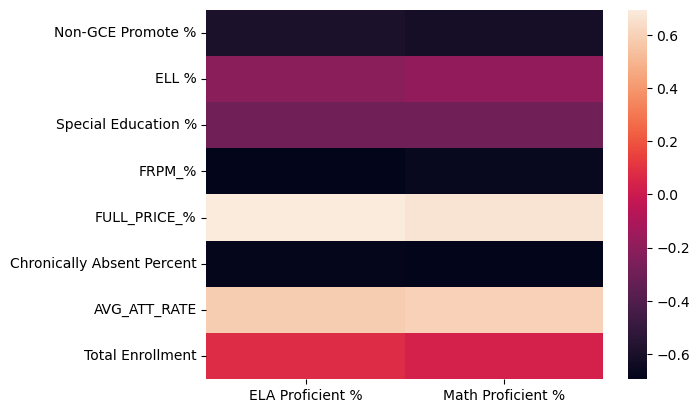

In [14]:
X = ["Non-GCE Promote %", "ELL %", "Special Education %", "FRPM_%", "FULL_PRICE_%", "Chronically Absent Percent", "AVG_ATT_RATE", "Total Enrollment"]
Y = ["ELA Proficient %", "Math Proficient %"]
subset = df[X + Y]
print(subset.head())
corrs = subset.corr().loc[X, Y]
plt.figure()
sns.heatmap(corrs)
plt.show()

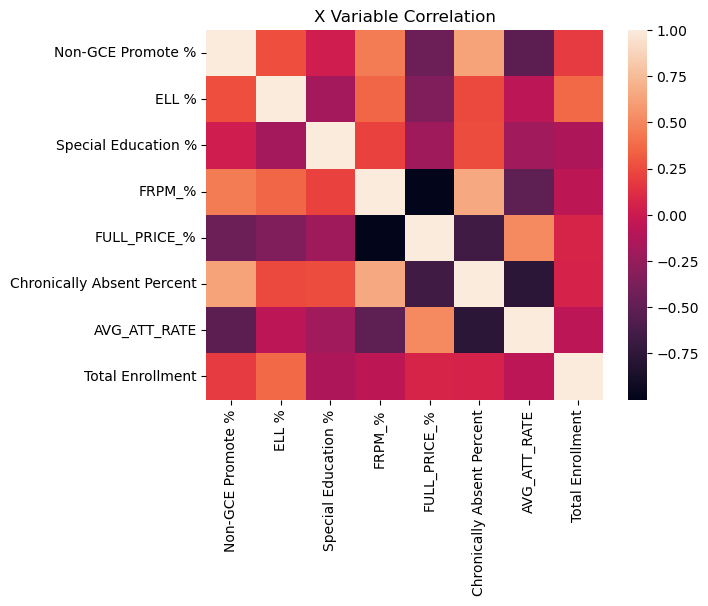

In [19]:
x_corr = df[X].corr()
plt.figure()
sns.heatmap(x_corr)
plt.title("X Variable Correlation")
plt.show()

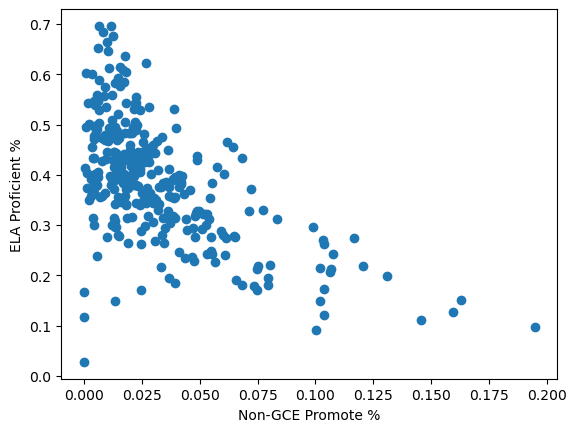

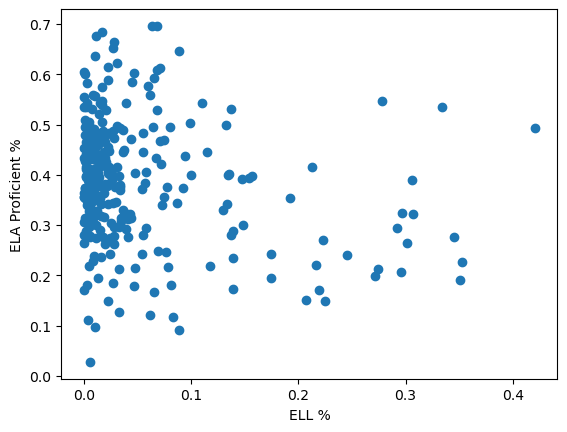

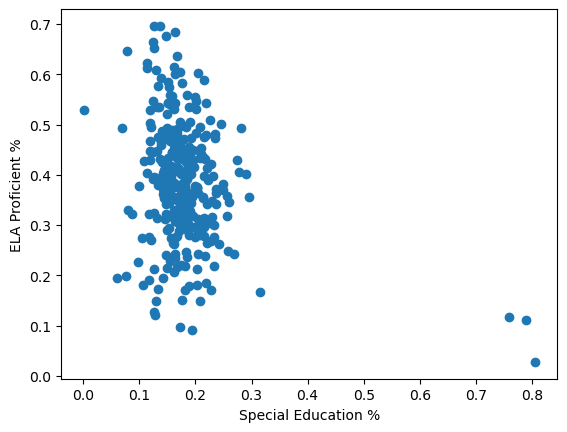

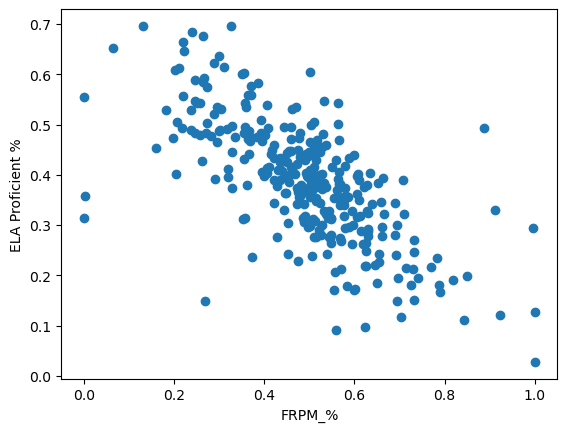

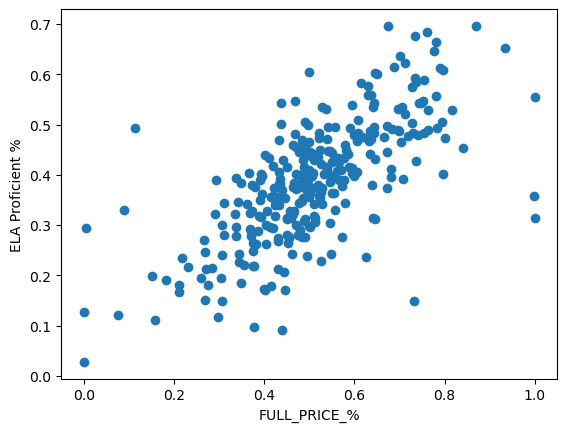

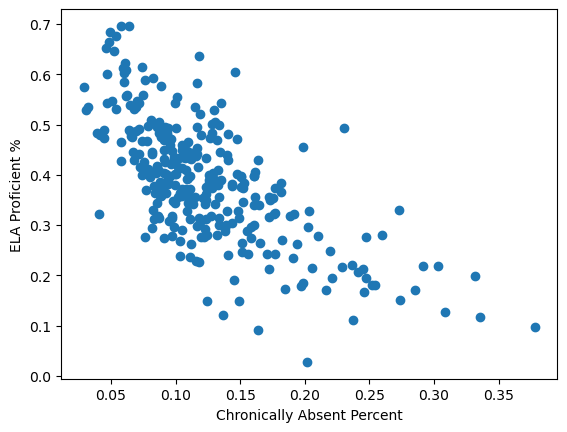

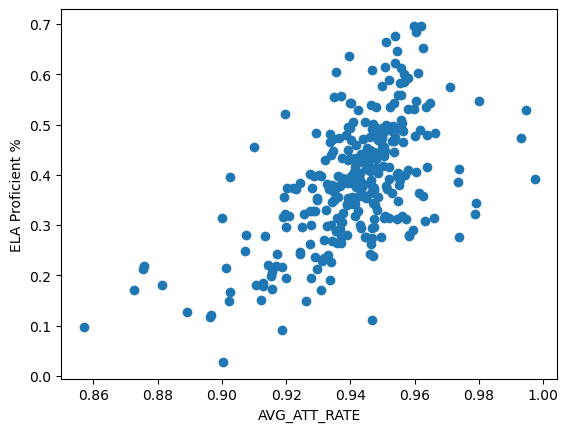

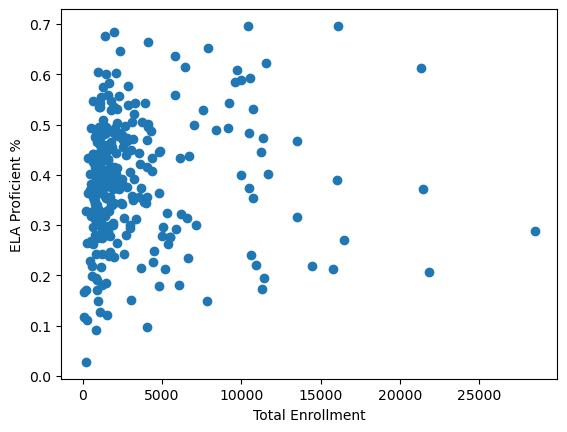

In [18]:
for col in X:
    plt.figure()
    plt.scatter(df[col], df["ELA Proficient %"])
    plt.xlabel(col)
    plt.ylabel("ELA Proficient %")
    plt.show()
    